I'm calling SNPs across all samples, so need to use list of all bamfiles

In order to determine how to filter the sites, need to calculate read depth. 

Therkildsen and Palumbi: excluding sites with a total read depth <300 and >3028 (mean depth +2 standard deviations

So need to calculate the mean total read depth (over all samples). 

Doing some other QC just to see

In [ ]:
~/angsd/angsd -P 15 -b /local/home/sarahgw/WGS/Sequences/filelists/All_Mylu.filelist -ref /local/home/sarahgw/references/Myotis_Lucifugus2.0/Myotis_lucifugus.Myoluc2.0.dna_sm.toplevel.fa -out /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu.qc -trim 0 -C 50 -baq 1 -minMapQ 20 -doQsDist 1 -doDepth 1 -doCounts 1 

In [8]:
!head /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu.qc.depthGlobal

0	34722506	24494187	18781257	15505279	13280089	11733819	10599736	9692502	9000465	8435610	7978920	7583040	7272834	6995445	6755575	6560813	6380016	6230125	6086109	5963864	5854799	5753869	5671724	5591462	5518181	5460487	5402144	5353746	5307400	5281874	5247629	5226749	5195715	5178369	5161880	5140600	5138194	5131957	5122806	5123212	5135911	5137450	5145039	5150701	5152173	5168505	5187396	5199103	5221822	5250111	5278970	5297134	5319020	5350320	5391335	5429049	5463923	5503061	5541364	5584375	5636101	5678599	5719778	5770230	5826837	5878937	5944000	5992944	6054056	6118908	6174548	6236423	6304204	6376630	6444535	6524525	6594344	6674012	6750969	6843660	6921796	7004729	7092571	7175919	7262555	7355076	7451900	7547228	7638831	7725831	7831129	7928781	8037637	8137687	8235763	8347101	8454697	8556569	8670231	1168380830	


It binned anything over 100. so, that's good half of the sites have coverage over 100, but we don't know the upper limit. I'm just going to set upper limit to 10,360 since that would mean that each individual would have greater than 10x depth 
Not setting lower limit since I'm setting -nInd to half the total number, so should eliminate anything that has super low depth

Redo SNP calling removing Myse samples:

'NJ_U_04_pairedplus_marked_dupes.bam' 

'NJ_U_14_pairedplus_marked_dupes.bam'

'VT_U_05_pairedplus_marked_dupes.bam' 

'VT_U_03_pairedplus_marked_dupes.bam' 

call SNPs with filters across all samples. only use sites that have information for at least half the individuals, I think this will be more helpful  


add -dogeno 32 and -dopost to this command so you calculate posterior genotype probabilities at the same time.


Trying multiple methods for allele frequency estimation just to compare these to the individual population allele freqs. 

In [ ]:
~/angsd/angsd -b /local/home/sarahgw/WGS/Sequences/filelists/All_Mylu.filelist -dogeno 32 -dopost 1 -GL 1 -doMajorMinor 1 -doMaf 11 -doCounts 1 -minQ 20 -minMapQ 30 -P 20 -SNP_pval 1e-6 -minInd 68 -setMaxDepth 10360 -out /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu

In [1]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu.mafs.gz

8255384 /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu.mafs.gz


Now calculate minor allele frequencies for each population for SNPS, first make sites index file

Include major and minor, so that these are consistent across populations, even if not accurate in a given (sub)population

In [2]:
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu.mafs.gz

In [6]:
!cut -f1-4 /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu.mafs > /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu_sites.txt

In [5]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu.mafs

92371964 /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu.mafs


So, we now have 92,371,964 SNPs!

In [7]:
!tail -n+2 /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu_sites.txt > /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu_sites1.txt

In [ ]:
~/angsd/angsd sites index All_mylu_sites1.txt

In [ ]:
for POP in NJ_U NY_U VT_U; do echo $POP; ~/angsd/angsd -b /local/home/sarahgw/WGS/Sequences/filelists/"$POP".filelist -GL 1 -doMajorMinor 3 -doMaf 11 -doCounts 1 -minQ 20 -minMapQ 30 -P 20 -setMaxDepth 10360 -sites /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu_sites1.txt -out /local/home/sarahgw/WGS/SNPS/All_mylu/"$POP"; echo "mafs done amphiprion" | mailx gw.sarah@gmail.com; done

In [ ]:
for POP in NJ_E NY_E VT_E; do echo $POP; ~/angsd/angsd -b /local/home/sarahgw/WGS/Sequences/filelists/"$POP".filelist -GL 1 -doMajorMinor 3 -doMaf 11 -doCounts 1 -minQ 20 -minMapQ 30 -P 20 -setMaxDepth 10360 -sites /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu_sites1.txt -out /local/home/sarahgw/WGS/SNPS/All_mylu/"$POP"; done

You need to:
calculate changes in allele frequency--SNP with highest change??
summarize differences in allele frequenceis between pops for mitochondrial and nuclear regions

In [5]:
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_E.mafs.gz
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_U.mafs.gz

In [6]:
!head /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_E.mafs

chromo	position	major	minor	knownEM	unknownEM	phat	nInd
GL429767	38	A	G	0.000000	0.000004	0.000000	15
GL429767	53	A	G	0.000000	0.000004	0.000000	15
GL429767	54	G	T	0.000000	0.000004	0.000000	15
GL429767	78	G	A	0.109899	0.109719	0.119721	13
GL429767	83	G	T	0.000000	0.000004	0.000000	14
GL429767	89	A	G	0.000000	0.000003	0.000000	13
GL429767	92	A	T	0.000000	0.000002	0.000000	12
GL429767	104	A	T	0.207668	0.207671	0.232022	11
GL429767	108	T	G	0.000000	0.000002	0.000000	12


In [20]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_E.mafs

109424282 /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_E.mafs


In [21]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_U.mafs

109424270 /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_U.mafs


In [22]:
!paste /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_E.mafs /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_U.mafs | awk '{print $1","$2","$3","$4","$5","$6","$8","$13","$14","$16}'>/local/home/sarahgw/WGS/SNPS/All_mylu/NJ_EU.mafs

In [41]:
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/NY_E.mafs.gz
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/NY_U.mafs.gz

In [42]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/NY_E.mafs
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/NY_U.mafs

109424282 /local/home/sarahgw/WGS/SNPS/All_mylu/NY_E.mafs
109424282 /local/home/sarahgw/WGS/SNPS/All_mylu/NY_U.mafs


In [43]:
!paste /local/home/sarahgw/WGS/SNPS/All_mylu/NY_E.mafs /local/home/sarahgw/WGS/SNPS/All_mylu/NY_U.mafs | awk '{print $1","$2","$3","$4","$5","$6","$8","$13","$14","$16}'>/local/home/sarahgw/WGS/SNPS/All_mylu/NY_EU.mafs

In [44]:
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/VT_E.mafs.gz
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/VT_U.mafs.gz

In [45]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/VT_E.mafs
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/VT_U.mafs

109424282 /local/home/sarahgw/WGS/SNPS/All_mylu/VT_E.mafs
109424282 /local/home/sarahgw/WGS/SNPS/All_mylu/VT_U.mafs


In [1]:
!paste /local/home/sarahgw/WGS/SNPS/All_mylu/VT_E.mafs /local/home/sarahgw/WGS/SNPS/All_mylu/VT_U.mafs | awk '{print $1","$2","$3","$4","$5","$6","$8","$13","$14","$16}'>/local/home/sarahgw/WGS/SNPS/All_mylu/VT_EU.mafs

In [38]:
f=open('/local/home/sarahgw/WGS/SNPS/All_mylu/NJ_EU.mafs', 'r')
o=open('/local/home/sarahgw/WGS/SNPS/All_mylu/NJ_EU2.mafs', 'w')
for line in f:
    scount=line.count(',')
    if scount==9:
        o.write(line)
    elif 0<=scount<9:
        groups=line.split(',')
        lineplus=','.join(groups[:2])+''.join([',']*(9-scount))+','+ ','.join(groups[2:])
        o.write(lineplus)  
o.close() 

In [40]:
!tail /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_EU2.mafs

AAPE02072767,3095,T,A,0.470258,0.470257,16,,,
AAPE02072767,3098,C,T,0.000000,0.000002,16,,,
AAPE02072780,302,G,A,0.000000,0.000001,16,,,
AAPE02072780,365,G,C,0.000000,0.000002,14,,,
AAPE02072780,367,A,C,0.048082,0.048083,14,,,
AAPE02072780,368,C,T,0.000000,0.000002,14,,,
AAPE02072780,369,T,C,0.000000,0.000004,14,,,
AAPE02072780,370,T,A,0.066391,0.066390,14,,,
AAPE02072780,372,T,C,0.000000,0.000003,14,,,
AAPE02072780,374,C,A,0.000000,0.000001,14,,,


In [10]:
!wc -l /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_EU.mafs

109424282 /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_EU.mafs


Calculate posterior genotype probabilities

In [ ]:
~/angsd/angsd -b /local/home/sarahgw/WGS/Sequences/filelists/All_Mylu.filelist -dogeno 32 -dopost 1 -gl 1 -domajorminor 1 -P 10 -domaf 1 -sites /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu_sites1.txt -out /local/home/sarahgw/WGS/SNPS/All_mylu_post

Create VCF file

In [ ]:
~/angsd/angsd -b /local/home/sarahgw/WGS/Sequences/filelists/All_Mylu.filelist -dovcf 1 -gl 1 -dopost 1 -domajorminor 3 -domaf 1 -sites /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu_sites1.txt -out /local/home/sarahgw/WGS/SNPS/All_mylu_postv 

In [ ]:
gunzip /local/home/sarahgw/WGS/SNPS/All_mylu_post.geno.gz

In [ ]:
~/ngsTools/ngsPopGen/ngsCovar -probfile /local/home/sarahgw/WGS/SNPS/All_mylu_post.geno -outfile /local/home/sarahgw/WGS/SNPS/All_mylu_post.geno -nind 136 -nsites 109424282 -call 0 -norm 0 &> /dev/null

In [8]:
!head -n 136 /local/home/sarahgw/WGS/Sequences/filelists/All_Mylu.filelist

NJ_E_01_pairedplus_marked_dupes.bam
NJ_E_02_pairedplus_marked_dupes.bam
NJ_E_04_pairedplus_marked_dupes.bam
NJ_E_23_pairedplus_marked_dupes.bam
NJ_E_24_pairedplus_marked_dupes.bam
NJ_E_25_pairedplus_marked_dupes.bam
NJ_E_26_pairedplus_marked_dupes.bam
NJ_E_28_pairedplus_marked_dupes.bam
NJ_E_29_pairedplus_marked_dupes.bam
NJ_E_30_pairedplus_marked_dupes.bam
NJ_E_05_pairedplus_marked_dupes.bam
NJ_E_06_pairedplus_marked_dupes.bam
NJ_E_07_pairedplus_marked_dupes.bam
NJ_E_08_pairedplus_marked_dupes.bam
NJ_E_10_pairedplus_marked_dupes.bam
NJ_E_22_pairedplus_marked_dupes.bam
NJ_E_13_pairedplus_marked_dupes.bam
NJ_E_14_pairedplus_marked_dupes.bam
NJ_E_15_pairedplus_marked_dupes.bam
NJ_E_16_pairedplus_marked_dupes.bam
NJ_E_18_pairedplus_marked_dupes.bam
NJ_E_21_pairedplus_marked_dupes.bam
NJ_U_01_pairedplus_marked_dupes.bam
NJ_U_02_pairedplus_marked_dupes.bam
NJ_U_03_pairedplus_marked_dupes.bam
NJ_U_04_pairedplus_marked_dupes.bam
NJ_U_05_pairedplus_marked_dupes.bam
NJ_U_06_pairedplus_marked_du

In [9]:
!Rscript -e 'write.table(cbind(seq(1,136),rep(1,136),c(rep("NJ_E",22),rep("NJ_U",22),rep("NY_E",21), rep("NY_U",22), rep("VT_E",27), rep("VT_U",22))), row.names=F, sep="\t", col.names=c("FID","IID","CLUSTER"), file="/local/home/sarahgw/WGS/SNPS/All_mylu/ALL_mylu.clst", quote=F)'

In [11]:
!tail /local/home/sarahgw/WGS/SNPS/All_mylu/ALL_mylu.clst

127	1	VT_U
128	1	VT_U
129	1	VT_U
130	1	VT_U
131	1	VT_U
132	1	VT_U
133	1	VT_U
134	1	VT_U
135	1	VT_U
136	1	VT_U


In [16]:
!Rscript /local/home/sarahgw/ngsTools/Scripts/plotPCA.R -i /local/home/sarahgw/WGS/SNPS/All_mylu/All_mylu_post.covar -c 1-2 -a /local/home/sarahgw/WGS/SNPS/All_mylu/ALL_mylu.clst -o /local/home/sarahgw/WGS/SNPS/All_mylu/ALL_mylu.pca.pdf

2.41 1.75 1.52 1.45 1.4 1.39 1.32 1.26 1.23 1.23 1.22 1.17 1.16 1.11 1.09 1.08 1.07 1.06 1.05 1.04 1.01 1.01 1 0.998 0.988 0.977 0.964 0.95 0.947 0.941 0.934 0.929 0.922 0.91 0.905 0.903 0.902 0.901 0.898 0.896 0.884 0.872 0.865 0.864 0.861 0.854 0.846 0.843 0.839 0.834 0.828 0.823 0.819 0.816 0.812 0.808 0.804 0.793 0.786 0.768 0.75 0.739 0.737 0.732 0.726 0.72 0.713 0.706 0.703 0.693 0.684 0.679 0.671 0.66 0.656 0.653 0.645 0.64 0.63 0.614 0.612 0.606 0.597 0.592 0.584 0.577 0.577 0.576 0.575 0.568 0.565 0.56 0.556 0.549 0.543 0.538 0.534 0.529 0.522 0.513 0.505 0.5 0.496 0.493 0.489 0.485 0.481 0.473 0.468 0.464 0.462 0.448 0.439 0.432 0.426 0.419 0.415 0.398 0.387 0.377 0.363 0.349 0.344 0.335 0.318 0.311 0.307 0.302 0.293 0.275 0.269 0.253 0.234 0.231 0.229 0.00259 
Saving 7 x 7 in image


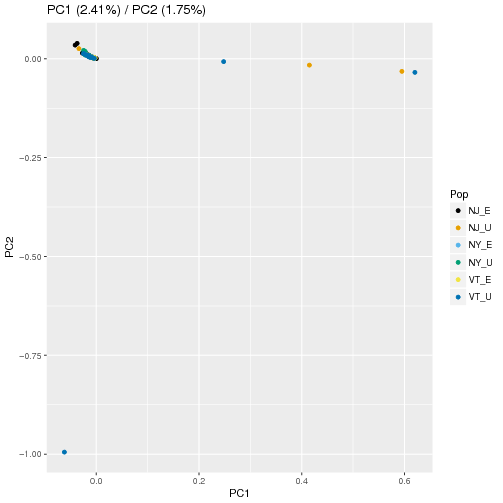

In [19]:
from wand.image import Image as WImage
img = WImage(filename='/local/home/sarahgw/WGS/SNPS/All_mylu/ALL_mylu.pca.pdf')
img

separate mafs for mitochondrial

In [ ]:
zgrep 'AAPE02072785' NJ_E.mafs.gz > NJ_E_AAPE02072785.mafs

In [ ]:
zgrep 'AAPE02072785' NJ_U.mafs.gz > NJ_U_AAPE02072785.mafs

look for associations for each group.
Paper on method for determining associations: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-231

In [ ]:
sed -e 's/NJ_E_.._pairedplus_marked_dupes.bam/1/g' -e 's/NJ_U_.._pairedplus_marked_dupes.bam/0/g' NJ.filelist > NJ_pheno.ybin

In [ ]:
sed -e 's/NY_E_.._pairedplus_marked_dupes.bam/1/g' -e 's/NY_U_.._pairedplus_marked_dupes.bam/0/g' NY.filelist > NY_pheno.ybin

In [ ]:
sed -e 's/VT_E_.._pairedplus_marked_dupes.bam/1/g' -e 's/VT_U_.._pairedplus_marked_dupes.bam/0/g' VT.filelist > VT_pheno.ybin

In [ ]:
!awk {print} /local/home/sarahgw/WGS/Sequences/filelists/VT_pheno.ybin

In [ ]:
!wc -l /local/home/sarahgw/WGS/Sequences/filelists/NJ_pheno.ybin

In [ ]:
/local/home/sarahgw/angsd/angsd -yBin /local/home/sarahgw/WGS/Sequences/filelists/NJ_pheno.ybin -doAsso 1 -GL 1 -out NJ_assoc -doMajorMinor 1 -doMaf 1 -minQ 20 -minMapQ 30 -SNP_pval 1e-6 -bam /local/home/sarahgw/WGS/Sequences/filelists/NJ.filelist -P 15

In [ ]:
/local/home/sarahgw/angsd/angsd -yBin /local/home/sarahgw/WGS/Sequences/filelists/NY_pheno.ybin -doAsso 1 -GL 1 -out NY_assoc -doMajorMinor 1 -doMaf 1 -minQ 20 -minMapQ 30 -SNP_pval 1e-6 -bam /local/home/sarahgw/WGS/Sequences/filelists/NY.filelist -P 15

In [ ]:
/local/home/sarahgw/angsd/angsd -yBin /local/home/sarahgw/WGS/Sequences/filelists/VT_pheno.ybin -doAsso 1 -GL 1 -out VT_assoc -doMajorMinor 1 -doMaf 1 -minQ 20 -minMapQ 30 -SNP_pval 1e-6 -bam /local/home/sarahgw/WGS/Sequences/filelists/VT.filelist -P 15; echo "VT Assoc done amphiprion" | mailx gw.sarah@gmail.com

ok so if this is true:
The likelihood ratio statistic. This statistic is chi square distributed with one degree of freedom
Then that means p less than 0.05 is greater than 3.84

Right, but you need to do a p adjustment to deal with false positives. Ok, so let's take it into R and calculate p value and correct. 
Wait, maybe this is already accounting for false positives, paper seems to indicate that, no mention of correcting? Oh, so for standard GWAS there is a set significance thresholde of 5 x 10 ^ -8

In [ ]:
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_assoc.lrt0.gz
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_assoc.mafs.gz
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/NY_assoc.lrt0.gz
!gunzip /local/home/sarahgw/WGS/SNPS/All_mylu/VT_assoc.lrt0.gz

Going to just try calculating sample allele frequency for snps for two populations, then I can maybe just look for highest changes in allele frequency like they did in tasmanian devil paper: https://www.nature.com/articles/ncomms12684#methods
Fitst, need to make indexes from list of snps so that you can input them as -sites file.

In [ ]:
/local/home/sarahgw/angsd/misc/realSFS print NJ_E.saf.idx NJ_U.saf.idx -r GL429767:6000000-6000100 > NJSaf_test

In [ ]:
!awk '{print NF; exit}' /local/home/sarahgw/WGS/SNPS/All_mylu/NJSaf_test 

Let's try doing doMaf-0 to see if that will give us allele frequencies? No, there is no output

Okay, now let's calculate the posterior genotype probabilities In order to do that we first need to do sfs with E and U separately. Since I'm not doing the whole thing, need to take first line make new sfs file, remember folded sfs has half as many categories as unfolded sfs

In [ ]:
~/angsd/misc/realSFS -P 20 NJ_E.saf.idx -nsites 1000000000 > NJ_E_sub.ml

In [ ]:
~/angsd/misc/realSFS -P 20 NJ_U.saf.idx -nsites 1000000000 > NJ_U_sub.ml

In [ ]:
./angsd -dopost 3 -b list -gl 1 -domajorminor 1 -domaf 1 -pest angsdput.saf.idx.ml -dogeno 2 -r 1 -out angsdput2

In [ ]:
~/angsd/angsd -dopost 3 -fold 1 -anc /local/home/sarahgw/references/Myotis_Lucifugus2.0/Myotis_lucifugus.Myoluc2.0.dna_sm.toplevel.fa -P 10 -b /local/home/sarahgw/WGS/Sequences/filelists/NJ_U.filelist 
-gl 1 -domajorminor 1 -domaf 1 -pest /local/home/sarahgw/WGS/SNPS/All_mylu/NJ_U_sub1.ml -minMapQ 30 -minQ 20 -dogeno 2 -out NJ_U_posterior

In [ ]:
~/angsd/angsd -P 10 -b /local/home/sarahgw/WGS/Sequences/filelists/NJ_E.filelist -fold 1 -anc /local/home/sarahgw/references/Myotis_Lucifugus2.0/Myotis_lucifugus.Myoluc2.0.dna_sm.toplevel.fa -dopost -sfs NJ_U_sub.ml -gl 1 -minMapQ 30 -minQ 20 -doMajorMinor 1 -out NJ_E_posterior